In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
import time

In [2]:
d = np.load("../data/training_data/splits.npz", allow_pickle=True)
X_train = d["X_train"]
X_test = d["X_test"]
y_train = d["y_train"]
y_test = d["y_test"]

In [5]:
f = np.load("../data/training_data/features_labels.npz", allow_pickle=True)
X = f["X"]
y = f["y"]

In [3]:
# Start with default parameters
rf_basic = RandomForestClassifier(random_state=42, n_jobs=-1)

# Train the model
start_time = time.time()
rf_basic.fit(X_train, y_train)
training_time = time.time() - start_time

# Make predictions
y_pred_basic = rf_basic.predict(X_test)

# Evaluate
accuracy_basic = accuracy_score(y_test, y_pred_basic)
print("Basic Random Forest Results:")
print(f"Accuracy: {accuracy_basic:.4f}")
print(f"Training time: {training_time:.2f} seconds")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_basic))

Basic Random Forest Results:
Accuracy: 0.9637
Training time: 0.11 seconds

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       425
           1       0.98      0.95      0.96       379
           2       0.94      0.95      0.94       397
           3       0.94      0.95      0.95       399

    accuracy                           0.96      1600
   macro avg       0.96      0.96      0.96      1600
weighted avg       0.96      0.96      0.96      1600



Top 10 Most Important Features:
       feature  importance
7    Feature_7    0.114627
15  Feature_15    0.096035
10  Feature_10    0.082621
5    Feature_5    0.073650
14  Feature_14    0.065914
11  Feature_11    0.064877
6    Feature_6    0.062100
0    Feature_0    0.055031
9    Feature_9    0.054721
13  Feature_13    0.054581




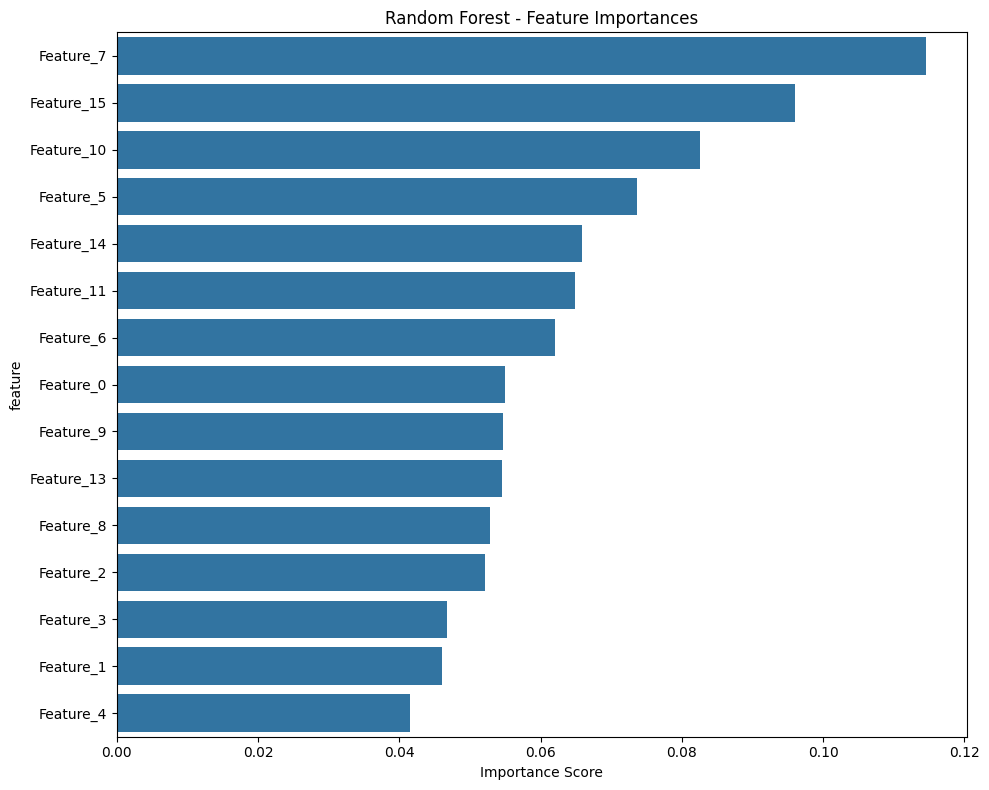

In [6]:
# Get feature importances
feature_importances = rf_basic.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'feature': X.columns if hasattr(X, 'columns') else [f'Feature_{i}' for i in range(X.shape[1])],
    'importance': feature_importances
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance_df.head(10))
print('\n')

# Plot feature importances
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance_df.head(15), x='importance', y='feature')
plt.title('Random Forest - Feature Importances')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

In [7]:
# Define parameter distribution for RandomizedSearch
param_dist = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

print("Starting Randomized Search for Random Forest...")
start_time = time.time()

# Perform randomized search
random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter combinations to try
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_train, y_train)

print(f"Randomized search completed in {time.time() - start_time:.2f} seconds")

# Best parameters and score
print("\nBest parameters found:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"Best cross-validation score: {random_search.best_score_:.4f}")

Starting Randomized Search for Random Forest...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Randomized search completed in 33.32 seconds

Best parameters found:
  n_estimators: 200
  min_samples_split: 2
  min_samples_leaf: 2
  max_features: sqrt
  max_depth: 50
  bootstrap: False
Best cross-validation score: 0.9592


In [8]:
# Create a DataFrame from cv_results_
results = pd.DataFrame(random_search.cv_results_)

# Columns to keep
keep = [
    "params",
    "mean_test_score",
    "std_test_score",
    "rank_test_score",
    "mean_fit_time",
    "mean_score_time",
    "std_fit_time"
]
df = results[keep].copy()

# Display top 10 parameter combinations by mean test score
df_sorted = df.sort_values("mean_test_score", ascending=False).reset_index(drop=True)
print("Top 10 parameter combinations by CV accuracy:")
df_sorted.head(10)

Top 10 parameter combinations by CV accuracy:


,params,mean_test_score,std_test_score,rank_test_score,mean_fit_time,mean_score_time,std_fit_time
0,"{'n_estimators': 200, 'min_samples_split': 2, ...",0.959219,0.003678,1,1.666006,0.166886,0.073192
1,"{'n_estimators': 200, 'min_samples_split': 5, ...",0.957969,0.006238,2,3.572265,0.254939,0.183569
2,"{'n_estimators': 500, 'min_samples_split': 5, ...",0.957969,0.005533,2,5.995907,0.259058,0.461257
3,"{'n_estimators': 500, 'min_samples_split': 5, ...",0.957188,0.004826,4,6.982218,0.651570,0.450977
4,"{'n_estimators': 100, 'min_samples_split': 5, ...",0.956719,0.005581,5,0.876257,0.179653,0.150102
5,"{'n_estimators': 100, 'min_samples_split': 10,...",0.952500,0.007516,6,1.099062,0.094122,0.062360
6,"{'n_estimators': 200, 'min_samples_split': 10,...",0.950156,0.006907,7,2.586672,0.234198,0.413455
7,"{'n_estimators': 200, 'min_samples_split': 10,...",0.950156,0.006907,7,3.035479,0.238580,0.139446
8,"{'n_estimators': 300, 'min_samples_split': 2, ...",0.948594,0.007613,9,3.624043,0.484608,0.352144
9,"{'n_estimators': 300, 'min_samples_split': 5, ...",0.948281,0.007133,10,3.210640,0.275006,0.178644


In [9]:
# Define parameter grid for GridSearch
param_grid = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
}

print("Starting Grid Search for Random Forest...")
start_time = time.time()

# Perform randomized search
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"Grid search completed in {time.time() - start_time:.2f} seconds")

# Best parameters and score
print("\nBest parameters found:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

Starting Grid Search for Random Forest...
Fitting 5 folds for each of 450 candidates, totalling 2250 fits
Grid search completed in 259.21 seconds

Best parameters found:
  max_depth: None
  max_features: sqrt
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 500
Best cross-validation score: 0.9586


In [10]:
# Create a DataFrame from cv_results_
results = pd.DataFrame(grid_search.cv_results_)

# Columns to keep
keep = [
    "params",
    "mean_test_score",
    "std_test_score",
    "rank_test_score",
    "mean_fit_time",
    "mean_score_time",
    "std_fit_time"
]
df = results[keep].copy()

# Display top 10 parameter combinations by mean test score
df_sorted = df.sort_values("mean_test_score", ascending=False).reset_index(drop=True)
print("Top 10 parameter combinations by CV accuracy:")
df_sorted.head(10)

Top 10 parameter combinations by CV accuracy:


,params,mean_test_score,std_test_score,rank_test_score,mean_fit_time,mean_score_time,std_fit_time
0,"{'max_depth': 50, 'max_features': 'log2', 'min...",0.958594,0.004222,1,5.779952,0.590801,0.174609
1,"{'max_depth': None, 'max_features': 'log2', 'm...",0.958594,0.004222,1,5.596758,0.939013,0.465997
2,"{'max_depth': 50, 'max_features': 'sqrt', 'min...",0.958594,0.004222,1,5.597987,0.584481,0.233500
3,"{'max_depth': None, 'max_features': 'sqrt', 'm...",0.958594,0.004222,1,4.269429,0.935664,0.490327
4,"{'max_depth': None, 'max_features': 'log2', 'm...",0.956719,0.004651,5,3.408434,0.235688,0.173618
5,"{'max_depth': None, 'max_features': 'sqrt', 'm...",0.956719,0.004651,5,2.229882,0.256364,0.178306
6,"{'max_depth': 50, 'max_features': 'sqrt', 'min...",0.956719,0.004651,5,3.346611,0.322155,0.147858
7,"{'max_depth': 50, 'max_features': 'log2', 'min...",0.956719,0.004651,5,3.462744,0.382133,0.406989
8,"{'max_depth': 30, 'max_features': 'log2', 'min...",0.956094,0.005875,9,5.723395,0.651033,0.293474
9,"{'max_depth': 30, 'max_features': 'sqrt', 'min...",0.956094,0.005875,9,5.763789,0.378694,0.288853


In [11]:
# Use the best model from tuning (choose either random_search or grid_search)
final_rf = random_search.best_estimator_  

# Make final predictions
y_pred_final = final_rf.predict(X_test)

# Comprehensive evaluation
final_accuracy = accuracy_score(y_test, y_pred_final)
print(f"\nFinal Random Forest Model Performance:")
print(f"Test Accuracy: {final_accuracy:.4f}")
print(f"Best Parameters: {random_search.best_params_}")
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_final))


Final Random Forest Model Performance:
Test Accuracy: 0.9644
Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': False}

Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       425
           1       0.98      0.95      0.96       379
           2       0.94      0.96      0.95       397
           3       0.94      0.95      0.95       399

    accuracy                           0.96      1600
   macro avg       0.96      0.96      0.96      1600
weighted avg       0.96      0.96      0.96      1600



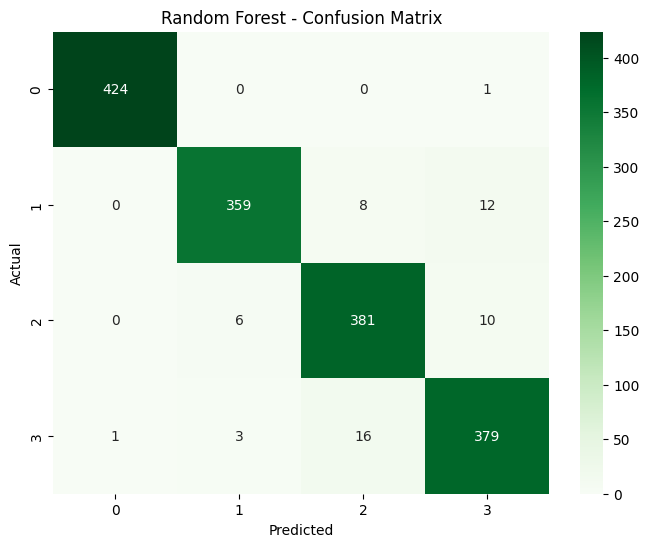

In [12]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.title('Random Forest - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [13]:
# Perform cross-validation on the best model
cv_scores = cross_val_score(final_rf, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)

print("Cross-Validation Results:")
print(f"CV Scores: {[f'{score:.4f}' for score in cv_scores]}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Cross-Validation Results:
CV Scores: ['0.9641', '0.9531', '0.9617', '0.9586', '0.9586']
Mean CV Accuracy: 0.9592 (+/- 0.0074)


n_estimators =  10: Train Accuracy = 0.9989, Test Accuracy = 0.9437
n_estimators =  50: Train Accuracy = 1.0000, Test Accuracy = 0.9631
n_estimators = 100: Train Accuracy = 1.0000, Test Accuracy = 0.9637
n_estimators = 200: Train Accuracy = 1.0000, Test Accuracy = 0.9650
n_estimators = 300: Train Accuracy = 1.0000, Test Accuracy = 0.9637
n_estimators = 400: Train Accuracy = 1.0000, Test Accuracy = 0.9650
n_estimators = 500: Train Accuracy = 1.0000, Test Accuracy = 0.9669


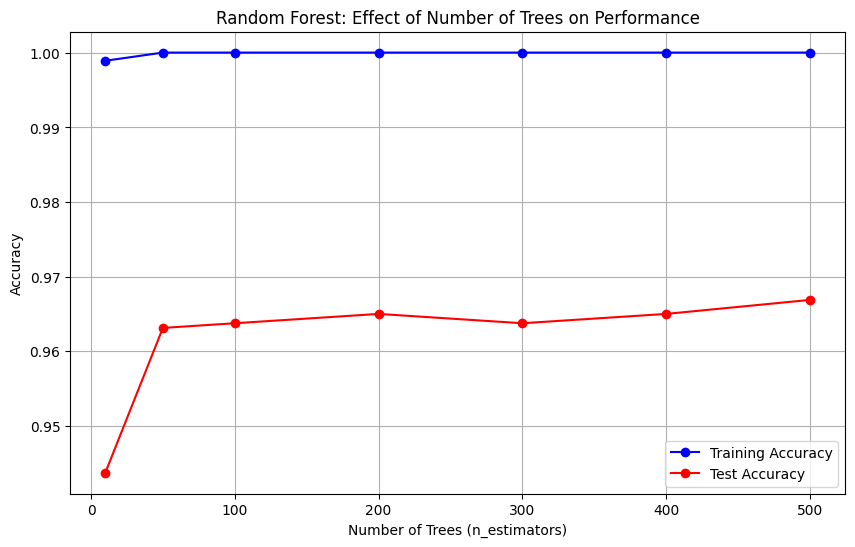

In [14]:
# Test different numbers of estimators
n_estimators_range = [10, 50, 100, 200, 300, 400, 500]
train_scores = []
test_scores = []

for n_est in n_estimators_range:
    rf_temp = RandomForestClassifier(
        n_estimators=n_est,
        random_state=42,
        n_jobs=-1
    )
    rf_temp.fit(X_train, y_train)

    # Training score
    train_pred = rf_temp.predict(X_train)
    train_acc = accuracy_score(y_train, train_pred)
    train_scores.append(train_acc)

    # Test score
    test_pred = rf_temp.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    test_scores.append(test_acc)

    print(f"n_estimators = {n_est:3d}: Train Accuracy = {train_acc:.4f}, Test Accuracy = {test_acc:.4f}")

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, train_scores, 'b-', label='Training Accuracy', marker='o')
plt.plot(n_estimators_range, test_scores, 'r-', label='Test Accuracy', marker='o')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Accuracy')
plt.title('Random Forest: Effect of Number of Trees on Performance')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# Random Forest provides OOB score which is like built-in cross-validation
rf_with_oob = RandomForestClassifier(
    n_estimators=100,
    oob_score=True,  # Enable OOB scoring
    random_state=42,
    n_jobs=-1
)

rf_with_oob.fit(X_train, y_train)

print(f"OOB Score: {rf_with_oob.oob_score_:.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, rf_with_oob.predict(X_test)):.4f}")

OOB Score: 0.9627
Test Accuracy: 0.9637
